# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission


In [2]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)



# Data

## Process the Metadata

In [3]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv")
display(df2d.head())

,Unnamed: 0,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,...,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,fold
0,0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,...,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
1,1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,...,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
2,2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,...,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
3,3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,...,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
4,4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,...,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0


## Create a Pytorch Dataset

In [4]:
from torchvision.transforms import PILToTensor

In [5]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
        
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
    
        
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    


In [6]:
dataset = Dataset_from_df(df2d[df2d['segmentations']],TRAIN_FOLDER)

In [7]:
dataset[665]['image'].max()

tensor(10672, dtype=torch.int32)

In [8]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(d['image'].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(rearrange(d['mask'].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    plt.axis('off')

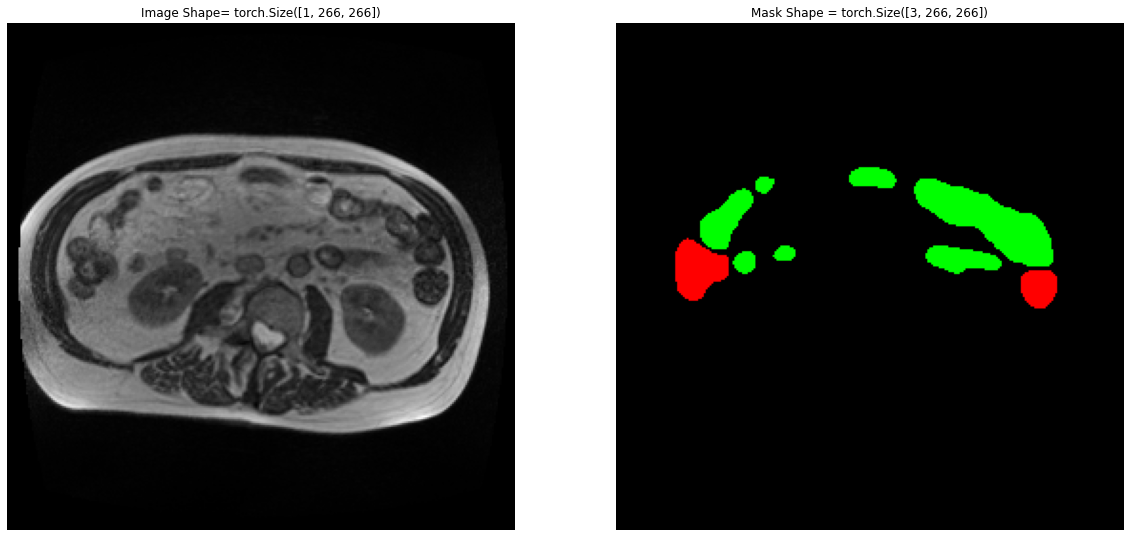

In [9]:
plot_data(dataset[665])

### With n fold cross validation we need a dataset for each fold

In [10]:
def prepare_datasets(df, fold, train_transforms, valid_transforms):
    train_df = df.query("fold!=@fold").query("segmentations==True").reset_index(drop=True)
    valid_df = df.query("fold==@fold").query("segmentations==True").reset_index(drop=True)

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER, transform=train_transforms)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER, transform=valid_transforms)
    
    return train_dataset, valid_dataset

# Training

In [11]:
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

## Loss Functions and Metrics

In [12]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Training Loops

In [13]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [14]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        output = model(images)
        with torch.no_grad():
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## Training

In [15]:
from torchvision import transforms

In [16]:
train_transforms = transforms.Compose(
    [transforms.CenterCrop((266,266)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((288,288))])

In [17]:
valid_transforms = transforms.Compose(
    [transforms.CenterCrop((266,266)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((288,288))])  # multiple of 32 for UUnet

In [18]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef


In [64]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()
    model_name_base = "Unet-1"

    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/(model_name_base+"fold-"+str(fold)+"-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.4953, Metric: 0.325,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.5357, Metric = 0.300
Fold: 0, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1797, Metric: 0.703,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6664, Metric = 0.079
Fold: 0, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1313, Metric: 0.769,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6650, Metric = 0.318
Fold: 0, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1146, Metric: 0.797,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6616, Metric = 0.318
Fold: 0, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1051, Metric: 0.812,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.7723, Metric = 0.318
Fold: 0, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0991, Metric: 0.822,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6638, Metric = 0.275
Fold: 0, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0891, Metric: 0.846,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.7185, Metric = 0.318
Fold: 0, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0842, Metric: 0.854,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.7075, Metric = 0.318
Fold: 0, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0755, Metric: 0.872,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.1452, Metric = 0.318
Fold: 0, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0724, Metric: 0.879,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.1868, Metric = 0.318
Fold: 0, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0672, Metric: 0.890,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.9126, Metric = 0.318
Fold: 0, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0643, Metric: 0.896,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.0303, Metric = 0.318
Fold: 0, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0588, Metric: 0.905,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.7187, Metric = 0.318
Fold: 0, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0563, Metric: 0.911,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.8787, Metric = 0.318
Fold: 0, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0530, Metric: 0.917,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.8292, Metric = 0.318
Fold: 0, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0500, Metric: 0.923,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.8099, Metric = 0.142
Fold: 0, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0479, Metric: 0.927,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6205, Metric = 0.332
Fold: 0, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0464, Metric: 0.930,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6278, Metric = 0.222
Fold: 0, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0451, Metric: 0.932,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.4993, Metric = 0.407
Fold: 0, Epoch: 20, LR: 1.252e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0444, Metric: 0.933,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1471, Metric = 0.770
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/Unet-1fold-0-1.pth
Fold: 1, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.5444, Metric: 0.250,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.9456, Metric = 0.167
Fold: 1, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1827, Metric: 0.700,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.9761, Metric = 0.264
Fold: 1, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1292, Metric: 0.772,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5946, Metric = 0.306
Fold: 1, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1140, Metric: 0.798,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6061, Metric = 0.306
Fold: 1, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1055, Metric: 0.812,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6984, Metric = 0.301
Fold: 1, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0968, Metric: 0.830,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6585, Metric = 0.306
Fold: 1, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0902, Metric: 0.842,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6221, Metric = 0.306
Fold: 1, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0829, Metric: 0.857,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6202, Metric = 0.306
Fold: 1, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0778, Metric: 0.867,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6524, Metric = 0.306
Fold: 1, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0748, Metric: 0.874,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6089, Metric = 0.306
Fold: 1, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0669, Metric: 0.890,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.7149, Metric = 0.306
Fold: 1, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0649, Metric: 0.894,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5932, Metric = 0.306
Fold: 1, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0602, Metric: 0.904,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.7151, Metric = 0.302
Fold: 1, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0564, Metric: 0.910,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5797, Metric = 0.263
Fold: 1, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0535, Metric: 0.917,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6942, Metric = 0.161
Fold: 1, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0506, Metric: 0.922,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.4403, Metric = 0.329
Fold: 1, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0482, Metric: 0.926,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6193, Metric = 0.319
Fold: 1, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0462, Metric: 0.929,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5972, Metric = 0.202
Fold: 1, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0452, Metric: 0.932,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.3718, Metric = 0.478
Fold: 1, Epoch: 20, LR: 1.252e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0445, Metric: 0.933,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1400, Metric = 0.785
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/Unet-1fold-1-1.pth
Fold: 2, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.5126, Metric: 0.300,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5737, Metric = 0.257
Fold: 2, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1683, Metric: 0.723,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5711, Metric = 0.308
Fold: 2, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1221, Metric: 0.788,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5864, Metric = 0.332
Fold: 2, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1151, Metric: 0.798,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5959, Metric = 0.332
Fold: 2, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1034, Metric: 0.818,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6168, Metric = 0.332
Fold: 2, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0949, Metric: 0.836,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6532, Metric = 0.332
Fold: 2, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0888, Metric: 0.847,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6113, Metric = 0.330
Fold: 2, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0818, Metric: 0.862,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6052, Metric = 0.332
Fold: 2, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0784, Metric: 0.868,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6097, Metric = 0.332
Fold: 2, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0710, Metric: 0.884,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6129, Metric = 0.332
Fold: 2, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0684, Metric: 0.888,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6717, Metric = 0.332
Fold: 2, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0630, Metric: 0.898,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6164, Metric = 0.332
Fold: 2, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0601, Metric: 0.903,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6757, Metric = 0.332
Fold: 2, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0558, Metric: 0.912,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5995, Metric = 0.332
Fold: 2, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0531, Metric: 0.918,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.7122, Metric = 0.332
Fold: 2, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.922,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5728, Metric = 0.332
Fold: 2, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.927,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5880, Metric = 0.330
Fold: 2, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.931,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.4158, Metric = 0.407
Fold: 2, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.933,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.3964, Metric = 0.390
Fold: 2, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0448, Metric: 0.935,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1691, Metric = 0.720
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/Unet-1fold-2-1.pth
Fold: 3, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.5099, Metric: 0.322,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.5530, Metric = 0.270
Fold: 3, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1774, Metric: 0.710,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 1.0573, Metric = 0.120
Fold: 3, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1315, Metric: 0.772,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.7379, Metric = 0.185
Fold: 3, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1185, Metric: 0.794,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6298, Metric = 0.328
Fold: 3, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1102, Metric: 0.808,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.9697, Metric = 0.010
Fold: 3, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1050, Metric: 0.816,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.8829, Metric = 0.328
Fold: 3, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0922, Metric: 0.841,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6277, Metric = 0.328
Fold: 3, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0836, Metric: 0.858,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.7330, Metric = 0.328
Fold: 3, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0814, Metric: 0.863,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.8739, Metric = 0.328
Fold: 3, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0740, Metric: 0.878,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.8237, Metric = 0.328
Fold: 3, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0678, Metric: 0.888,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6764, Metric = 0.162
Fold: 3, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0667, Metric: 0.891,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 1.0660, Metric = 0.328
Fold: 3, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0615, Metric: 0.901,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.7379, Metric = 0.283
Fold: 3, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0579, Metric: 0.908,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.7441, Metric = 0.326
Fold: 3, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0543, Metric: 0.915,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6896, Metric = 0.328
Fold: 3, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0514, Metric: 0.920,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.5957, Metric = 0.121
Fold: 3, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0490, Metric: 0.925,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6528, Metric = 0.327
Fold: 3, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0474, Metric: 0.928,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.3576, Metric = 0.391
Fold: 3, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0461, Metric: 0.931,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1947, Metric = 0.673
Fold: 3, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0458, Metric: 0.932,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1048, Metric = 0.824
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/Unet-1fold-3-1.pth
Fold: 4, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.4941, Metric: 0.337,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.5502, Metric = 0.315
Fold: 4, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1744, Metric: 0.712,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7787, Metric = 0.206
Fold: 4, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1254, Metric: 0.782,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7029, Metric = 0.174
Fold: 4, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1147, Metric: 0.798,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7201, Metric = 0.166
Fold: 4, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1034, Metric: 0.819,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7656, Metric = 0.259
Fold: 4, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0968, Metric: 0.831,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6064, Metric = 0.069
Fold: 4, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0895, Metric: 0.846,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6940, Metric = 0.315
Fold: 4, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0827, Metric: 0.860,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7213, Metric = 0.315
Fold: 4, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0756, Metric: 0.873,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6666, Metric = 0.315
Fold: 4, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0718, Metric: 0.880,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.9079, Metric = 0.315
Fold: 4, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0675, Metric: 0.888,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6467, Metric = 0.166
Fold: 4, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0630, Metric: 0.897,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6426, Metric = 0.259
Fold: 4, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0594, Metric: 0.905,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6795, Metric = 0.315
Fold: 4, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0561, Metric: 0.912,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7463, Metric = 0.313
Fold: 4, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0536, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6156, Metric = 0.276
Fold: 4, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0501, Metric: 0.923,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.5834, Metric = 0.092
Fold: 4, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0480, Metric: 0.926,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.5876, Metric = 0.288
Fold: 4, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0466, Metric: 0.929,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.4170, Metric = 0.272
Fold: 4, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0452, Metric: 0.932,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.4517, Metric = 0.258
Fold: 4, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.933,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1435, Metric = 0.776
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/Unet-1fold-4-1.pth


## Do some trial inference on the validation set

In [21]:
model_name_base = "Unet-1"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [23]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/(model_name_base+"fold-"+str(fold)+"-1.pth"))
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [24]:
train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=8,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [25]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [26]:
output.max()

tensor(14.3027, device='cuda:0', grad_fn=<MaxBackward1>)

In [50]:
def plot_result(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

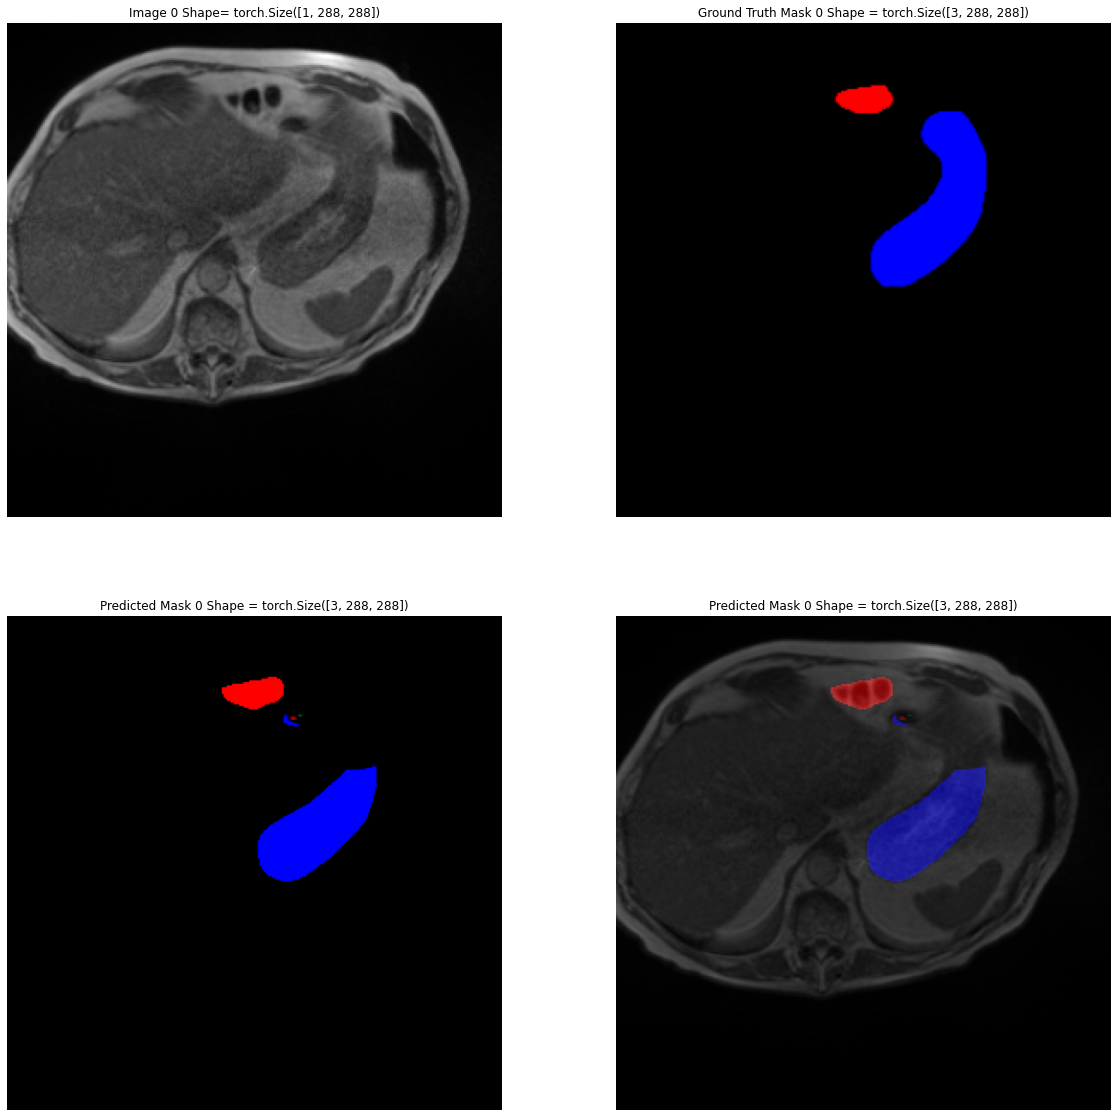

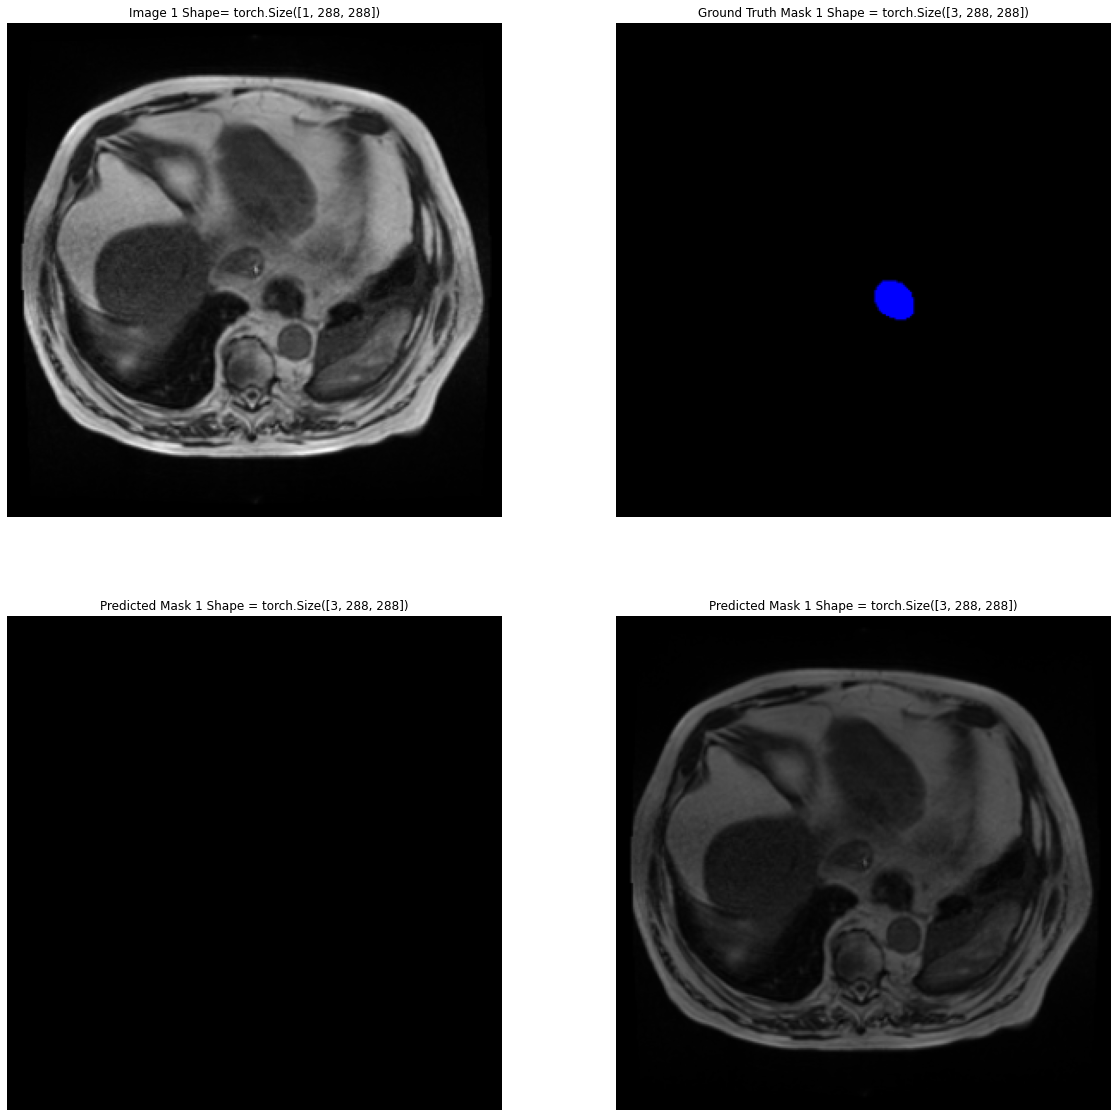

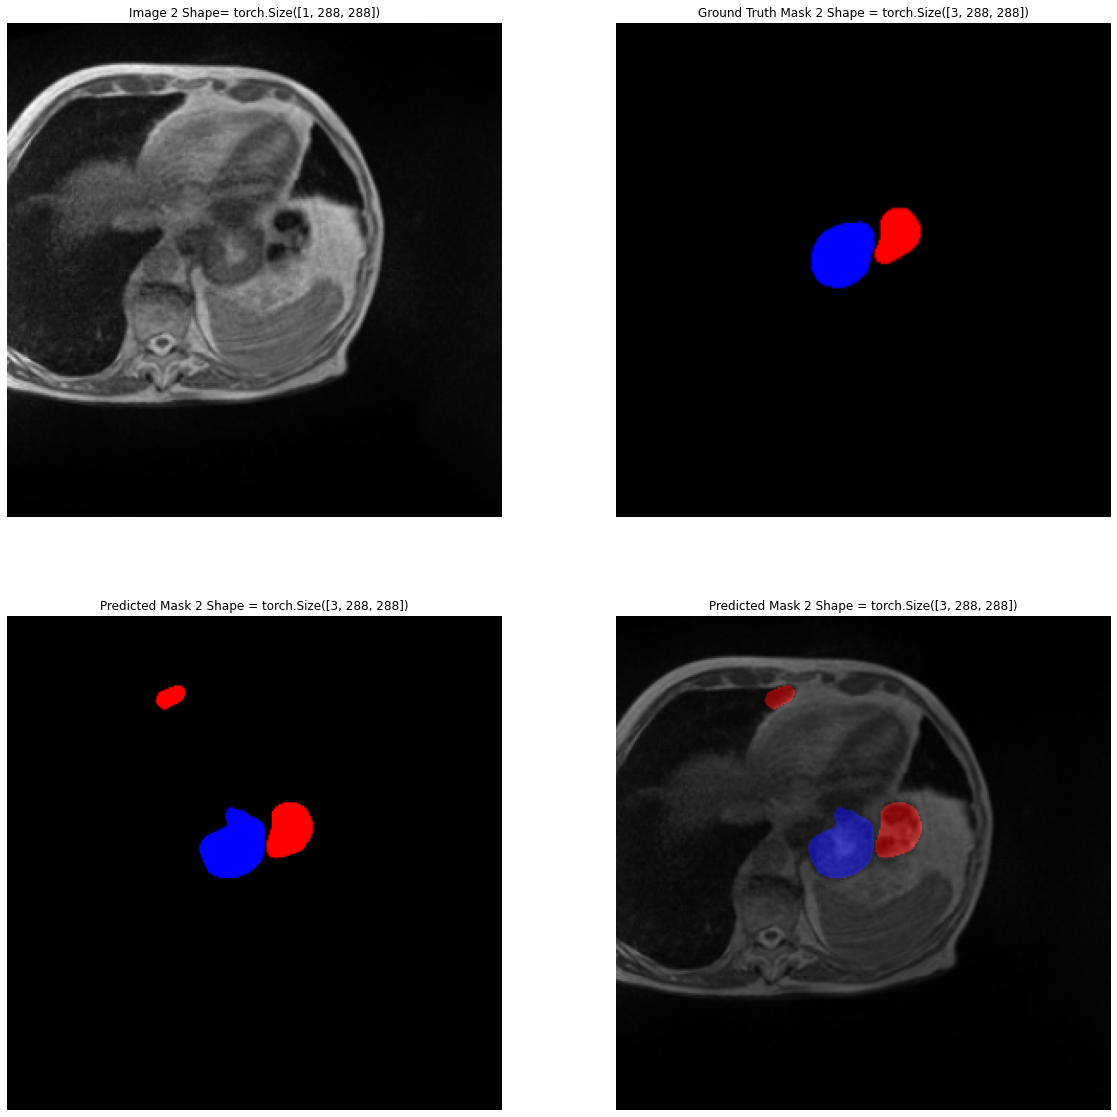

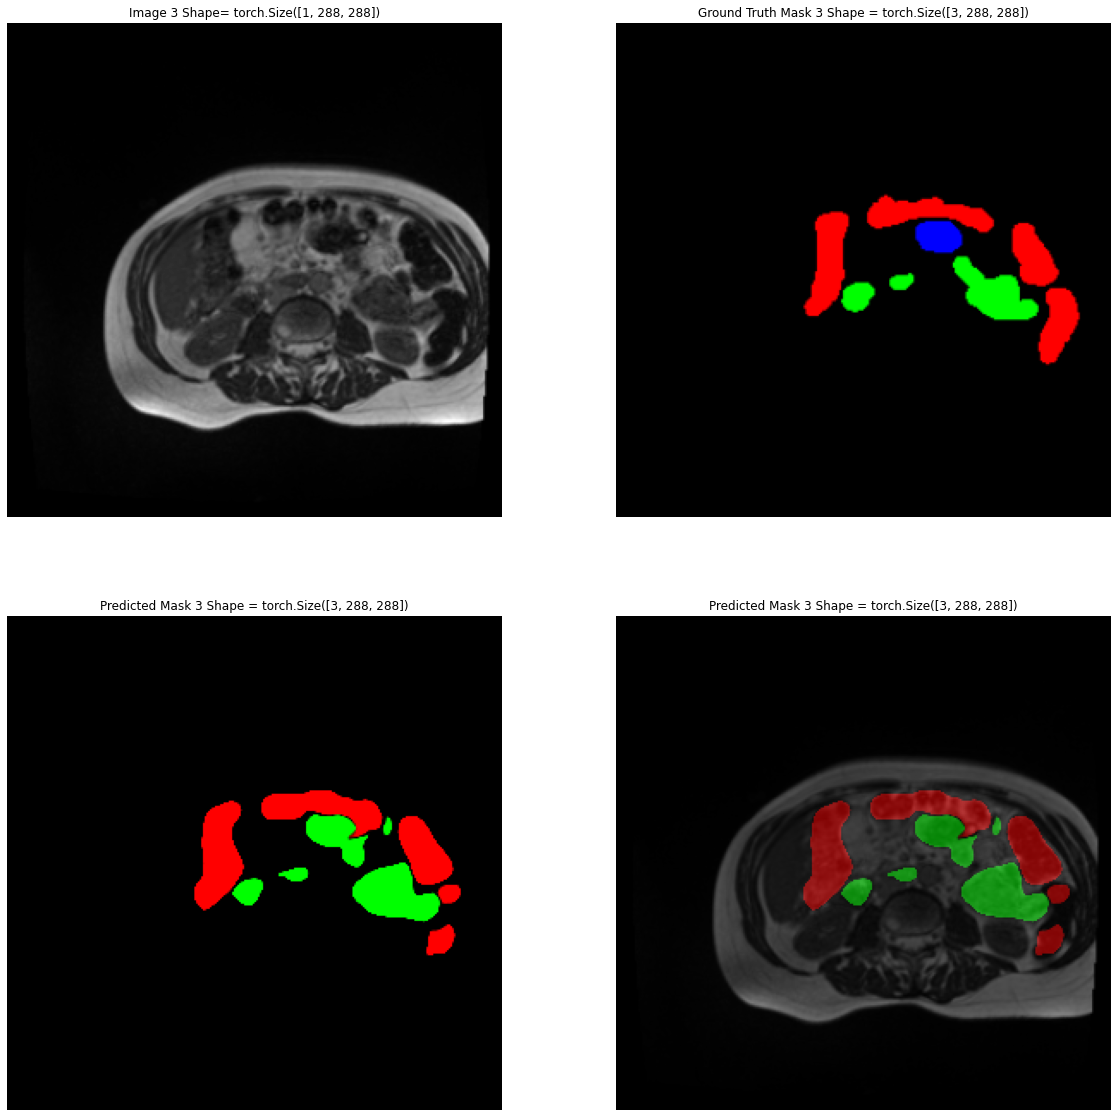

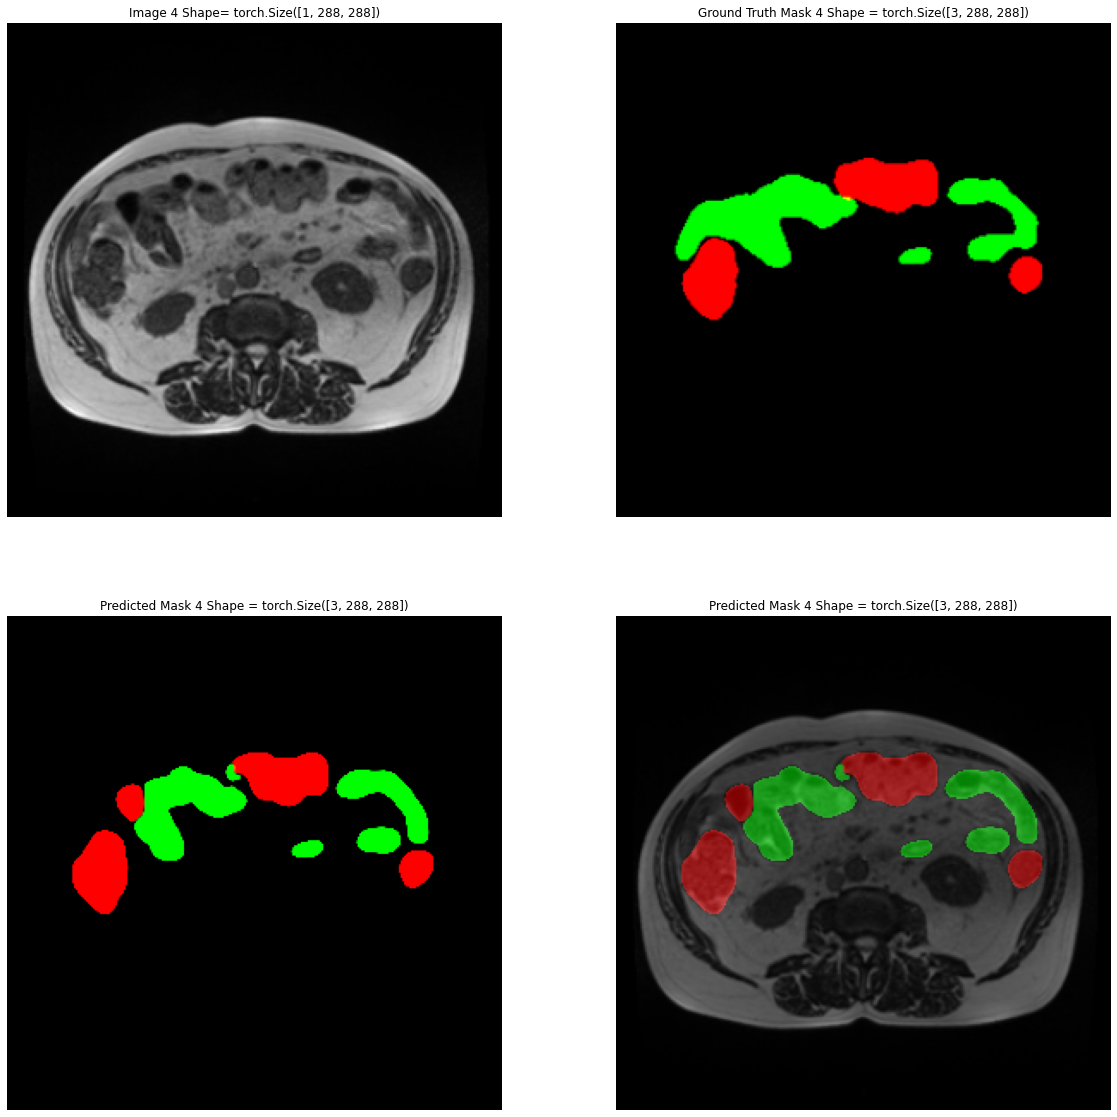

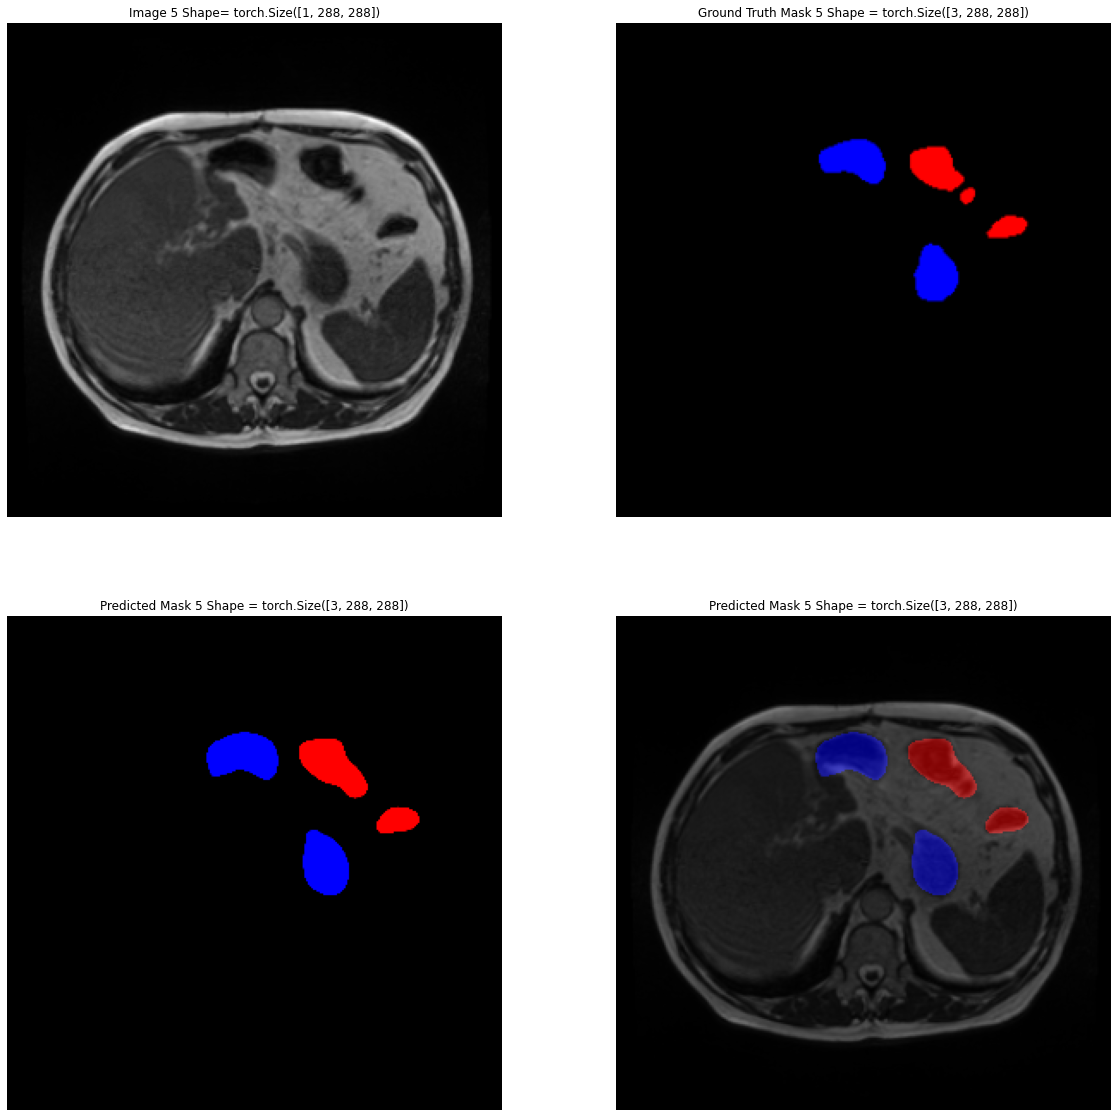

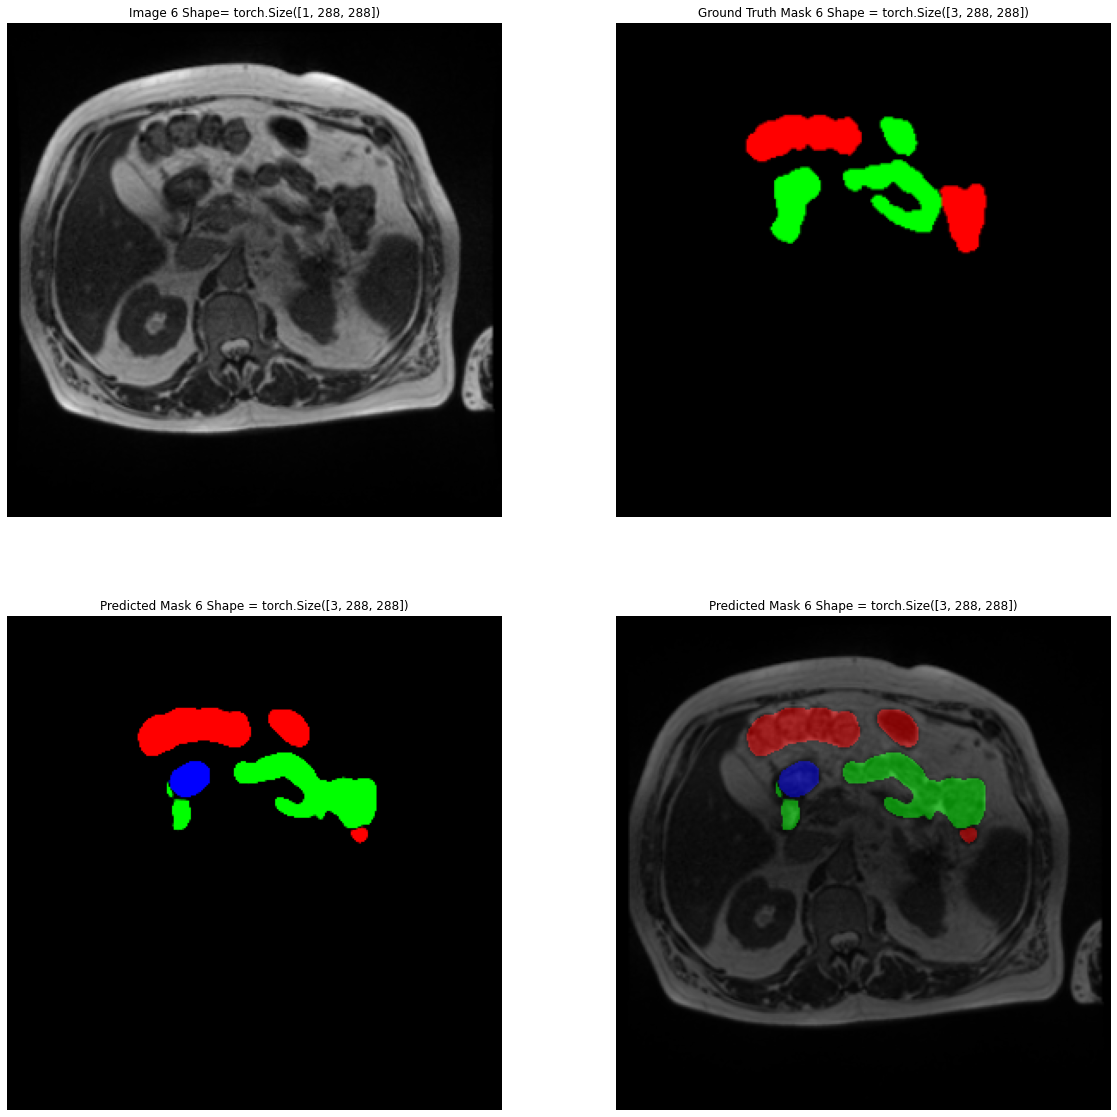

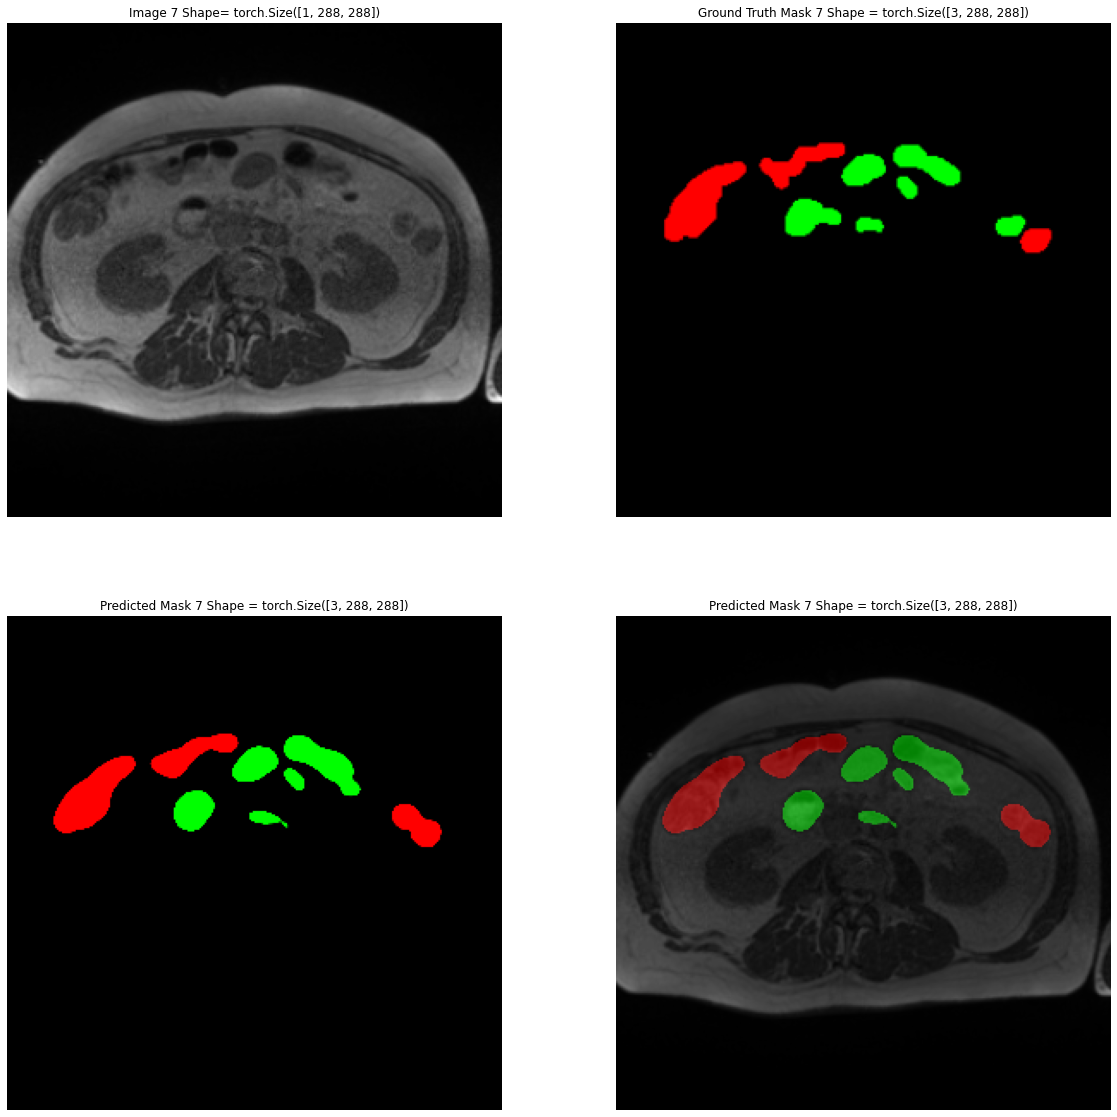

In [53]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)